In [59]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import scipy.stats as sc

In [60]:
# Read in Metadata
basefolder = ""
plotsfolder = 'plots'
namesfile = "all_sample_metadata.csv"
raw_data_folder = "raw data"
cleaned_data_folder = "cleaned data"
metadata = pd.read_csv(os.path.join(basefolder, namesfile))
# exclude samples with unknown age
metadata_age = metadata[~metadata['Age'].isin(['Unknown', 'nk'])]
metadata_gDNA = metadata_age[metadata_age['gDNA']==1]
metadata_gDNA['Age'] = metadata_gDNA['Age'].apply(lambda x: int(x))
metadata_gDNA_GCA = metadata_gDNA[metadata_gDNA['GCA Status']==1]

/Users/wbr/opt/anaconda3/envs/leeds/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [61]:
def determine_disease(row):
    if row['GCA Status'] == 1:
        disease = 'GCA'
    elif row['PNH Status'] == 1 or row['AA Status'] == 1:
        disease = 'PNH or AA'
    elif row['Health Status'] == 1:
        disease = 'Healthy'
    return disease
metadata_gDNA['Disease'] = [determine_disease(x) for i,x in metadata_gDNA.iterrows()]

/Users/wbr/opt/anaconda3/envs/leeds/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


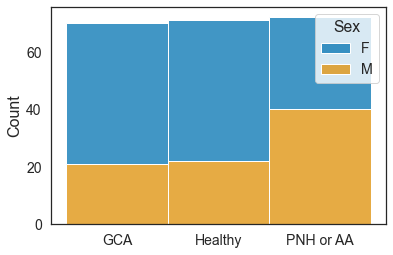

In [62]:
# Dataset Overview Plots
sns.set_theme(style="white", palette="colorblind", font_scale=1.3)
fig, ax = plt.subplots()

# Plot Data
sns.histplot(x=metadata_gDNA['Disease'], hue=metadata_gDNA['Sex'], multiple='stack', legend=True)
# Style
ax.set_ylabel('Count',fontsize=16)
ax.tick_params(labelsize=14)                                     
ax.set_xlabel('')
plt.savefig(os.path.join(basefolder, plotsfolder,'samples_per_group_sex.pdf'))

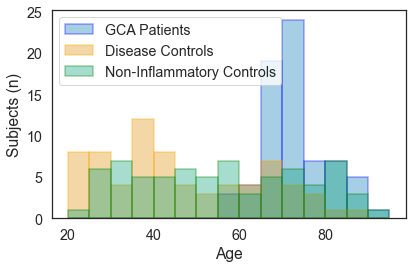

In [63]:
# Age Distribution

sns.set_theme(style="white", palette="colorblind", font_scale=1.3)

gca_subset = metadata_gDNA[metadata_gDNA['GCA Status'] == 1]
darren_subset = pd.concat([ metadata_gDNA[metadata_gDNA['PNH Status'] == 1], metadata_gDNA[metadata_gDNA['AA Status'] == 1]])
healthy_subset = metadata_gDNA[metadata_gDNA['Health Status'] == 1]

plt.hist(gca_subset['Age'], alpha=0.35, linewidth=1.5, edgecolor='blue', label='GCA Patients',bins=[20, 25, 30, 35, 40,45, 50,55, 60,65, 70, 75, 80, 85, 90, 95])
plt.hist(darren_subset['Age'], alpha=0.35, linewidth=1.5, edgecolor='orange', label='Disease Controls',bins=[20, 25, 30, 35, 40,45, 50,55, 60,65, 70, 75, 80, 85, 90, 95])
plt.hist(healthy_subset['Age'], alpha=0.35, linewidth=1.5, edgecolor='green', label='Non-Inflammatory Controls',bins=[20, 25, 30, 35, 40,45, 50,55, 60,65, 70, 75, 80, 85, 90, 95])
plt.legend()
plt.ylabel('Subjects (n)')
plt.xlabel('Age')
plt.tight_layout()
plt.savefig(os.path.join(basefolder, plotsfolder,'age_distribution_allsamples.pdf'))

In [89]:
control_ages = [x for x in darren_subset['Age']] 
control_ages.extend([x for x in healthy_subset['Age']])
print('Median age controls: ',np.median(control_ages), 'pm',sc.iqr(control_ages))
print('Median age GCA: ',np.median(gca_subset['Age']), 'pm',sc.iqr(gca_subset['Age']))

print(sc.mannwhitneyu(gca_subset['Age'], control_ages))

Median age controls:  48.0 pm 31.0
Median age GCA:  72.0 pm 9.0
MannwhitneyuResult(statistic=8237.0, pvalue=1.998595332989348e-14)


In [71]:
# Preprocessing Effects
# Nr of reads per sample before and after
reads_before = []
reads_after = []
clones_before = []
clones_after = []
for name in metadata_gDNA_GCA['Name']:
    original_sample = pd.read_csv(
        os.path.join(basefolder, raw_data_folder, "GCA_gDNA", name+'_clones_inclNN.txt'),
        delimiter='\t'
        )
    cleaned_sample = pd.read_csv(
        os.path.join(basefolder, cleaned_data_folder, name+'_clones_inclNN_cleaned_2.txt')
        )
    reads_before.append(np.sum(original_sample['cloneCount']))
    reads_after.append(np.sum(cleaned_sample['cloneCount']))
    clones_before.append(len(original_sample))
    clones_after.append(len(cleaned_sample))
    #break

Mean clones before cleaning  2505.5  +-  2082.0
Mean clones after cleaning  1429.5  +-  1277.5


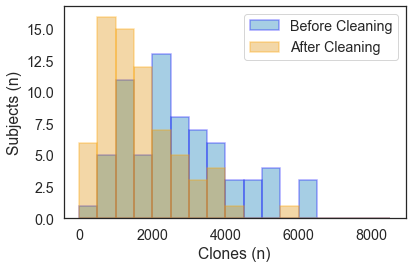

In [72]:
# Clones Distribution

print('Mean clones before cleaning ', np.median(clones_before), ' +- ', sc.iqr(clones_before))
print('Mean clones after cleaning ', np.median(clones_after), ' +- ', sc.iqr(clones_after))
sns.set_theme(style="white", palette="colorblind", font_scale=1.3)
plt.hist(clones_before, alpha=0.35, linewidth=1.5, edgecolor='blue', label='Before Cleaning',bins=[0, 500, 1000, 1500, 2000,2500, 3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500])
plt.hist(clones_after, alpha=0.35, linewidth=1.5, edgecolor='orange', label='After Cleaning',bins=[0, 500, 1000, 1500, 2000,2500, 3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500])
plt.legend()
plt.ylabel('Subjects (n)')
plt.xlabel('Clones (n)')
plt.tight_layout()
plt.savefig(os.path.join(basefolder, plotsfolder,'cleaning_clones.pdf'))

Mean reads before cleaning  127258.0  +-  103094.25
Mean reads after cleaning  126229.0  +-  103602.25


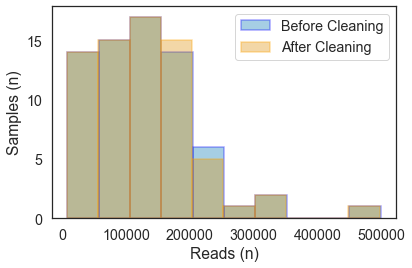

In [73]:
# Reads Distribution
print('Mean reads before cleaning ', np.median(reads_before), ' +- ', sc.iqr(reads_before))
print('Mean reads after cleaning ', np.median(reads_after), ' +- ', sc.iqr(reads_after))
plt.hist(reads_before, alpha=0.35, linewidth=1.5, edgecolor='blue', label='Before Cleaning')
plt.hist(reads_after, alpha=0.35, linewidth=1.5, edgecolor='orange', label='After Cleaning')
plt.legend()
#plt.title('Reads Before and After Cleaning')
plt.ylabel('Samples (n)')
plt.xlabel('Reads (n)')
plt.tight_layout()
plt.savefig(os.path.join(basefolder, plotsfolder,'cleaning_reads.pdf'))

In [74]:
extraction_dates = pd.read_csv(os.path.join(basefolder,'extraction_dates.csv'))
extraction_dates['Name'] = extraction_dates.apply(lambda x: str(x.ID)+'-'+x.Sample, axis=1)
extraction_dates['ID'] = [str(x) for x in extraction_dates['ID']]
extraction_dates_gDNA = extraction_dates[extraction_dates['Sample'] == 'gDNA']
extraction_dates_gDNA_GCA = extraction_dates_gDNA[extraction_dates_gDNA['ID'].isin(set(metadata_gDNA_GCA['ID']))]
extraction_dates_gDNA_GCA

,ID,Sample,Date,Method,Batch,Name
0,14538,gDNA,NaN,SC,NaN,14538-gDNA
1,18073,gDNA,NaN,SC,NaN,18073-gDNA
2,18077,gDNA,NaN,SC,NaN,18077-gDNA
3,18079,gDNA,NaN,SC,NaN,18079-gDNA
4,18082,gDNA,NaN,SC,NaN,18082-gDNA
...,...,...,...,...,...,...
67,17730,gDNA,03.03.20,GC,0.0,17730-gDNA
68,17783,gDNA,12.03.20,GC,0.0,17783-gDNA
69,17785,gDNA,01.06.20,GC,0.0,17785-gDNA
70,12324,gDNA,30.06.20,GC,0.0,12324-gDNA


In [75]:
# Sequence Overlap before and after cleaning
overlapping_clones_before = pd.DataFrame()
overlapping_clones_after = pd.DataFrame()
sample_lengths = {}

# Step 1: Get all sequences
for name in metadata_gDNA_GCA['Name']:
    original_sample = pd.read_csv(
        os.path.join(basefolder, raw_data_folder, "GCA_gDNA", name+'_clones_inclNN.txt'),
        delimiter='\t'
        )
    original_sample['Name'] = [name.split('/')[-1].split('_')[0] for i in range(len(original_sample))]
    cleaned_sample = pd.read_csv(
        os.path.join(basefolder, cleaned_data_folder, name+'_clones_inclNN_cleaned_2.txt')
        )
    cleaned_sample['Name'] = [name.split('/')[-1].split('_')[0] for i in range(len(cleaned_sample))]
    overlapping_clones_before = pd.concat(
                [overlapping_clones_before, original_sample],
                ignore_index=True
            )
    overlapping_clones_after = pd.concat(
                [overlapping_clones_after, cleaned_sample],
                ignore_index=True
            )

# Step 2: Exclude those that occur only once or twice
count_dict_before = Counter(overlapping_clones_before['aaSeqCDR3'])
count_dict_after = Counter(overlapping_clones_after['aaSeqCDR3'])
exclude1 = [x for x in count_dict_before if count_dict_before[x] < 3]
exclude2 = [x for x in count_dict_after if count_dict_after[x] < 3]
overlapping_clones_before = overlapping_clones_before[~overlapping_clones_before['aaSeqCDR3'].isin(exclude1)]
overlapping_clones_after = overlapping_clones_after[~overlapping_clones_after['aaSeqCDR3'].isin(exclude2)]
print(len(overlapping_clones_before), len(overlapping_clones_after))

33525 1923


In [76]:
# Samples ordered by date of extraction
ordered_samples = extraction_dates_gDNA_GCA['Name']
shared_seqs_before = np.zeros([len(ordered_samples), len(ordered_samples)])
shared_seqs_relative_before = np.zeros([len(ordered_samples), len(ordered_samples)])
for i, sample_i in enumerate(ordered_samples):
    clones_i = set(overlapping_clones_before[overlapping_clones_before['Name'] == sample_i]['aaSeqCDR3'])
    for j, sample_j in enumerate(ordered_samples): 
        clones_j = set(overlapping_clones_before[overlapping_clones_before['Name'] == sample_j]['aaSeqCDR3'])
        if sample_i != sample_j:
            shared_seqs_before[i,j] = len(clones_i.intersection(clones_j))
            if len(clones_i)+len(clones_j) == 0:
                shared_seqs_relative_before[i,j] = 0
            else:
                shared_seqs_relative_before[i,j] = len(clones_i.intersection(clones_j))/(len(clones_i)+len(clones_j))

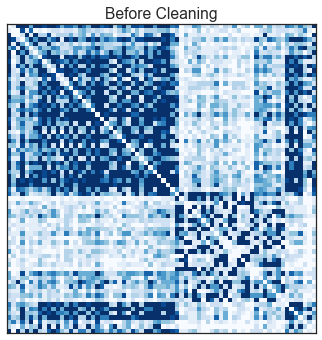

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(10,5)) 
img = ax.imshow(shared_seqs_before, cmap='Blues', vmax = 10)
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
#cbar = plt.colorbar(img)
#cbar.ax.set_title('# shared seq',fontsize=16)
plt.title('Before Cleaning')
plt.tight_layout()
plt.savefig(os.path.join(basefolder, plotsfolder, 'overlap_before_cleaning.pdf'))

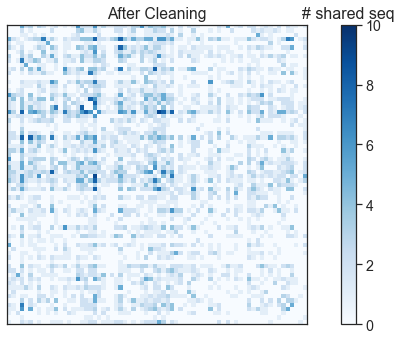

In [78]:
ordered_samples = extraction_dates_gDNA_GCA['Name']
shared_seqs_after = np.zeros([len(ordered_samples), len(ordered_samples)])
shared_seqs_relative_after = np.zeros([len(ordered_samples), len(ordered_samples)])
for i, sample_i in enumerate(ordered_samples):
    clones_i = set(overlapping_clones_after[overlapping_clones_after['Name'] == sample_i]['aaSeqCDR3'])
    for j, sample_j in enumerate(ordered_samples): 
        clones_j = set(overlapping_clones_after[overlapping_clones_after['Name'] == sample_j]['aaSeqCDR3'])
        if sample_i != sample_j:
            shared_seqs_after[i,j] = len(clones_i.intersection(clones_j))
            if len(clones_i)+len(clones_j) == 0:
                shared_seqs_relative_after[i,j] = 0
            else:
                shared_seqs_relative_after[i,j] = len(clones_i.intersection(clones_j))/(len(clones_i)+len(clones_j))
fig, ax = plt.subplots(1, 1, figsize=(10,5))
img = ax.imshow(shared_seqs_after, cmap='Blues', vmax = 10)
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
cbar = plt.colorbar(img)
cbar.ax.set_title('# shared seq',fontsize=16)
plt.title('After Cleaning')
plt.tight_layout()

plt.savefig(os.path.join(basefolder, plotsfolder, 'overlap_after_cleaning.pdf'))